In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Data/Mall_Customers.csv", sep=',')

In [4]:
df.shape

(200, 5)

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

## Análise exploratória dos dados

In [8]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [9]:
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].median()

Age                       36.0
Annual Income (k$)        61.5
Spending Score (1-100)    50.0
dtype: float64

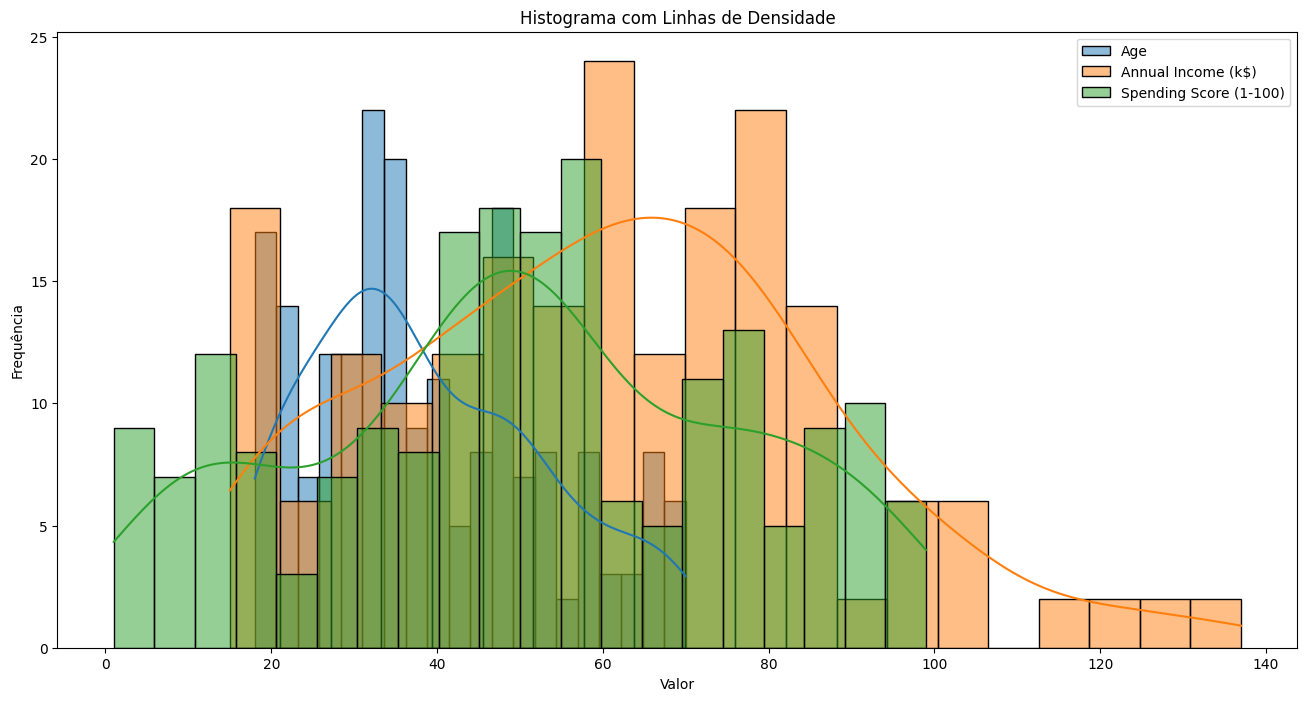

In [10]:
selected_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(16, 8))
for column in selected_columns:
    sns.histplot(data=df, x=column, kde=True, bins=20, label=column) # type: ignore

plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.title('Histograma com Linhas de Densidade')
plt.legend()
plt.show()

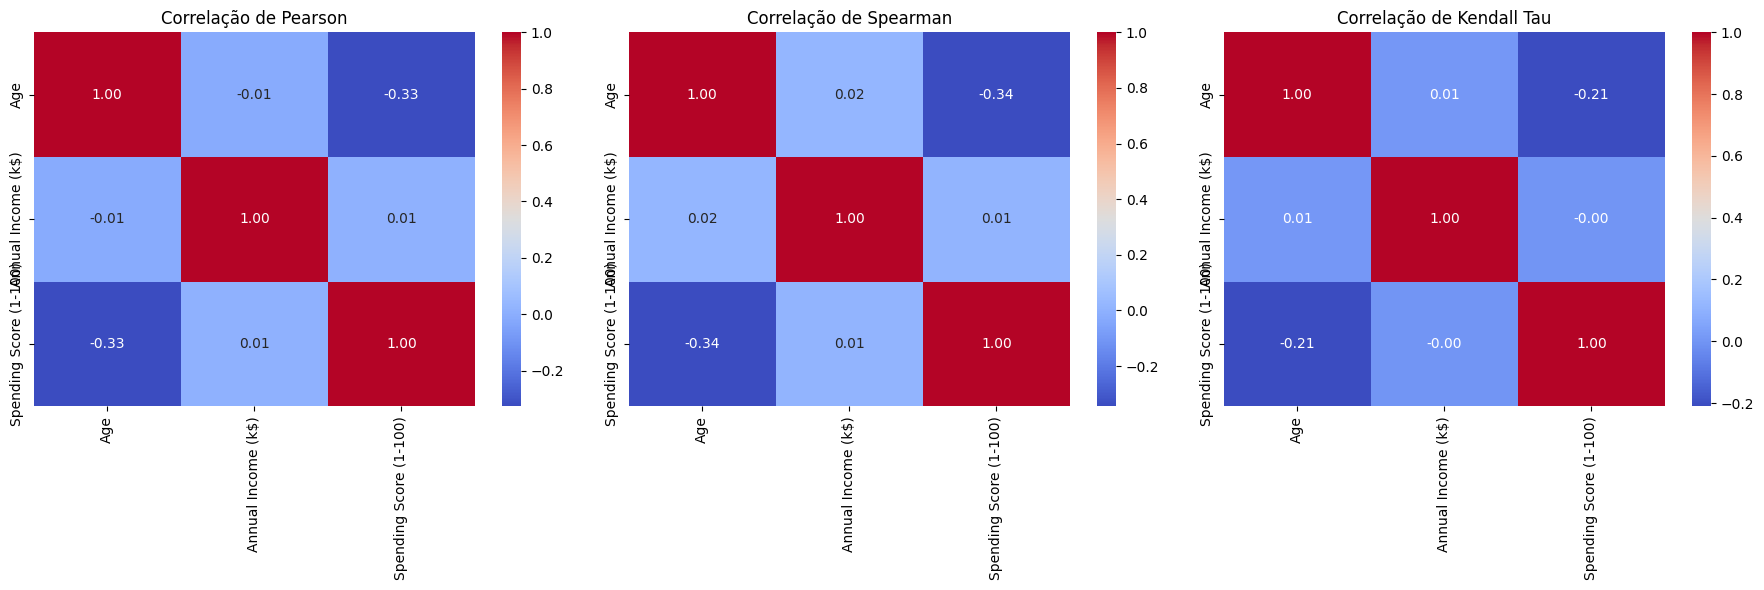

In [11]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(df[selected_columns].corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlação de Pearson')

plt.subplot(1, 3, 2)
sns.heatmap(df[selected_columns].corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlação de Spearman')

plt.subplot(1, 3, 3)
sns.heatmap(df[selected_columns].corr(method='kendall'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlação de Kendall Tau')

plt.tight_layout()
plt.show()

In [12]:
df['Gender'].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

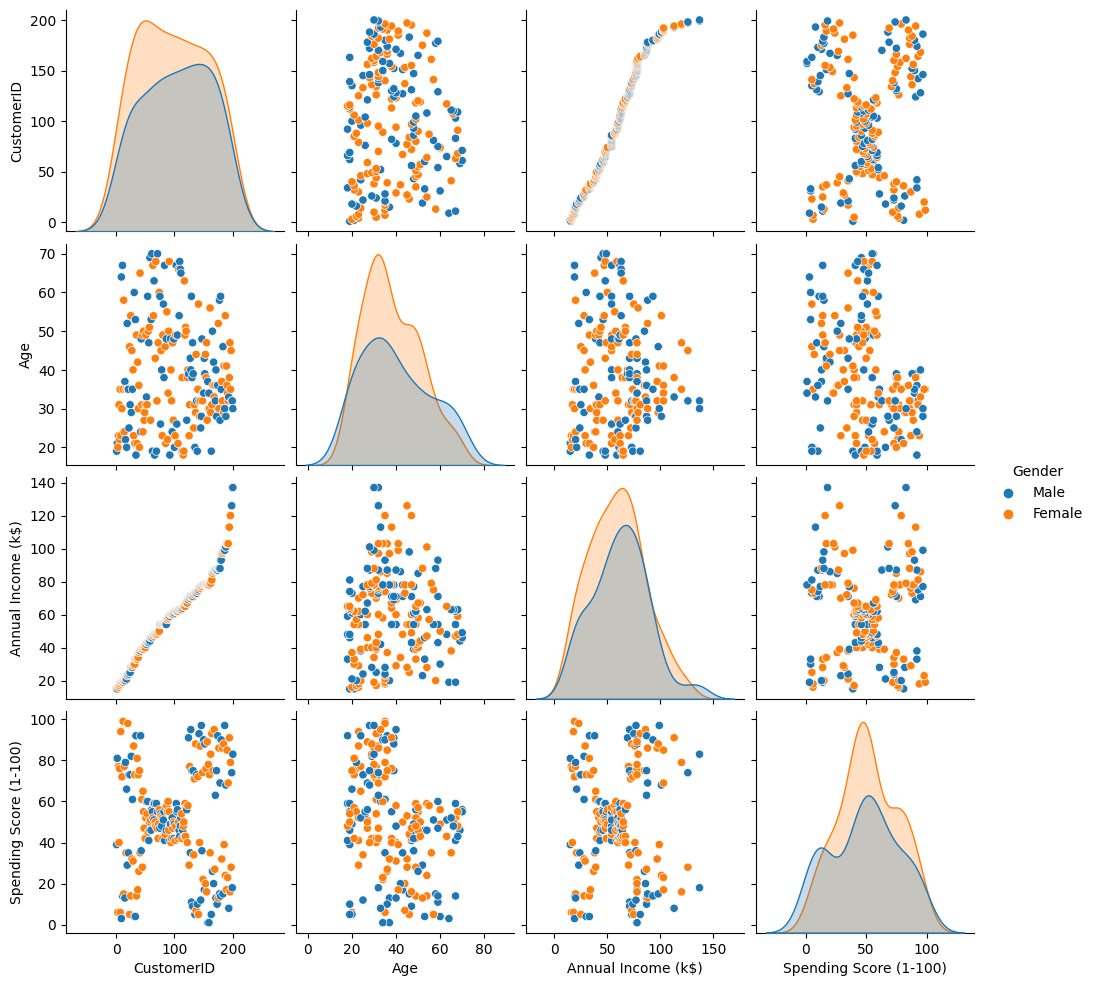

In [13]:
sns.pairplot(df, hue="Gender")
plt.show()

## Feature Scaling

In [14]:
scaler = StandardScaler()
scaler.fit(df[['Annual Income (k$)','Spending Score (1-100)']])
df_scaler = scaler.transform(df[['Annual Income (k$)','Spending Score (1-100)']])

### Elbow method - determinar o número apropriado de clusters.

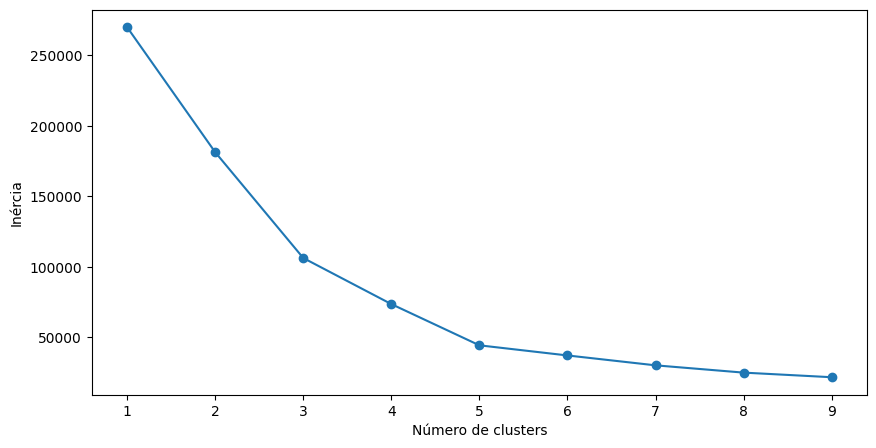

In [15]:
k = list(range(1, 10))
sse = []

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    sse.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(k, sse, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

In [ ]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [34]:
kmeans = KMeans(random_state=42)

param_grid = {
    'n_clusters': [5],
    'init': ['k-means++', 'random'],  # Métodos de inicialização dos centróides
    'n_init': [10, 20, 30],  # Número de inicializações diferentes
    'max_iter': [100, 200, 300],  # Número máximo de iterações
    'tol': [1e-4, 1e-5, 1e-6],  # Tolerância para convergência
    'algorithm': ['elkan', 'lloyd']  # Algoritmo K-Means
}

grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)

grid_search.fit(X)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação cruzada:", grid_search.best_score_)

best_kmeans = grid_search.best_estimator_
centroides = best_kmeans.cluster_centers_
best_kmeans_labels = best_kmeans.predict(X)

score = calinski_harabasz_score(X, best_kmeans_labels)
print("Melhor pontuação (Calinski-Harabasz):", score)

silhouette_avg = silhouette_score(X, best_kmeans_labels)
print("Coeficiente de silhueta:", silhouette_avg)
df['Grupos'] = best_kmeans_labels
df.head()

Melhores parâmetros: {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'n_init': 10, 'tol': 0.0001}
Melhor pontuação de validação cruzada: -31514.570654859745
Melhor pontuação (Calinski-Harabasz): 247.35899338037282
Coeficiente de silhueta: 0.553931997444648


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Grupos
0,1,Male,19,15,39,2
1,2,Male,21,15,81,3
2,3,Female,20,16,6,2
3,4,Female,23,16,77,3
4,5,Female,31,17,40,2


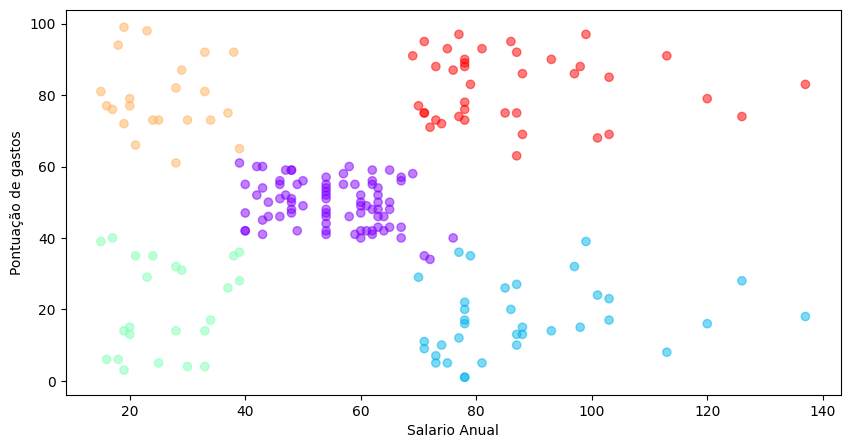

In [38]:
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=best_kmeans_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')
# plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5) # type: ignore
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [37]:
dbscan = DBSCAN(eps=10, min_samples=8, algorithm='auto')
dbscan.fit(X)
dbscan_labels = dbscan.labels_

score = calinski_harabasz_score(X, dbscan_labels)
print("Melhor pontuação (Calinski-Harabasz):", score)
silhouette_avg = silhouette_score(X, dbscan_labels)
print("Coeficiente de silhueta:", silhouette_avg)

Melhor pontuação (Calinski-Harabasz): 42.23595546342582
Coeficiente de silhueta: 0.36328873885121793


### Com outliers

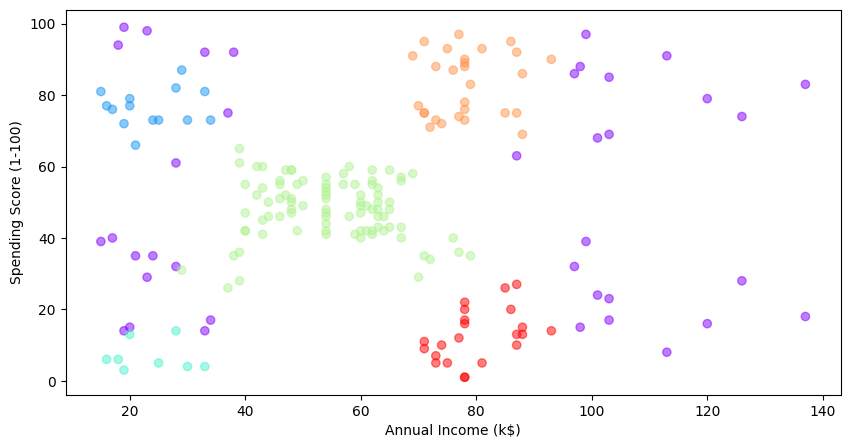

In [39]:
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=dbscan_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Sem outliers

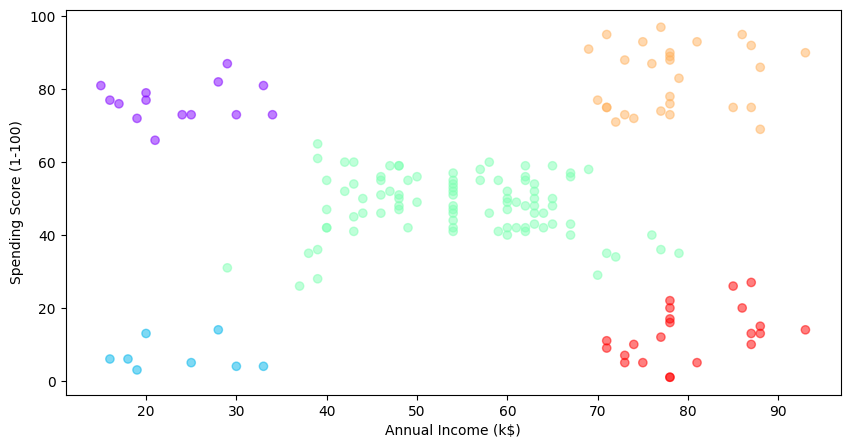

In [40]:
mascara = dbscan_labels>=0
plt.scatter(df[['Annual Income (k$)']][mascara], df[['Spending Score (1-100)']][mascara], c=dbscan_labels[mascara], alpha=0.5, cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [42]:
adjusted_rand_score(best_kmeans_labels, dbscan_labels)

0.7151933782093212

## Validação

Tipos:
- Interna: Quanto bom foi o meu agrupamento?
- Externa: Como parecido estão os meus dois algoritmos comparados?

### Avaliando o Desempenho dos Algoritmos

### Tipo Externo:

(a) Usando o **Adjusted Rand Index**

Compara o desempenho quando forem fornecidos datasets com labels geradas de forma aleatória. Quando essas labels estão muito diferente, o valor se aproxima de 0, o que sugere um resultado negativo, ou seja, clusters não próximos.

#### Tipo interno:

(b) Avaliando a métrica de **Silhouette**

Mede o formato do cluster obtido: avalia a distância entre os centros dos clusters, nesse caso, queremos maximizar as distâncias)

Valores próximos a -1, significa clusters ruins, próximo a 1, clusters bem separados.